<a href="https://colab.research.google.com/github/simseoyoung/Deep-Learning/blob/main/CH.6/VAE(Fashion%20MNSIT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variable AutoEncoder

 - fashion mnist dataset 사용



In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import random

import pandas as pd

from torchvision.utils import save_image

from tensorflow.keras import datasets

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cpu


In [33]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

[1] Data processing

In [34]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

print("x_train 의 length = {}".format(len(x_train)))
print("x_test 의 length = {}".format(len(x_test)))

x_train 의 length = 60000
x_test 의 length = 10000


In [ ]:
x_train=np.asarray(x_train)
y_train=np.asarray(y_train)
x_test=np.asarray(x_test)
y_test=np.asarray(y_test)

# Rescale the image data to 0 ~ 1. 
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

print("x_train 의 shape={}, x_test 의 shape={}".format(x_train.shape, x_test.shape))

x_train 의 shape=(60000, 28, 28), x_test 의 shape=(10000, 28, 28)


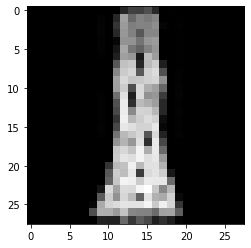

In [ ]:
# load dataset using dataloader
batch_size = 256

# batch size 만큼 나누어서 data를 로드
train_loader = torch.utils.data.DataLoader(x_train ,batch_size=batch_size, shuffle=True, num_workers=0,drop_last=False)
test_loader = torch.utils.data.DataLoader(x_test ,batch_size=len(x_test), shuffle=False, num_workers=0,drop_last=False)

for batch_idx, image in enumerate(train_loader):
    plt.imshow(image[0].reshape(28,28), cmap="gray")
    break

[2] Model

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # encoder 의 hidden layer
        self.fc1 = nn.Linear(784, 400) 
        self.mu = nn.Linear(400, 20) # reparameterization 을 위한 20개의 gaussian 분포에 대한 mean
        self.logvar = nn.Linear(400, 20) # reparameterization 을 위한 20개의 gaussian 분포에 대한 variance        

        self.fc2 = nn.Linear(20, 400)    
        self.fc3 = nn.Linear(400, 784)
        
    # Encoder
    # hidden layer 를 한번만 통과 한 후 mu 와 variance 의 2개의 output layer 를 return 한다
    
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.mu(h1)
        logvar = self.logvar(h1)
        
        # linear 를 통과한 값은 - 의 값이 나오는 경우가 존재한다
        # 이것을 방지하기 위해 linear 를 통과한 값은 var 가 아닌 log-variance 로 임의로 정해준다.
        #(variance 는 항상 양수라는 guarantee 를 갖게 하기 위함)
        # 즉 encoder 의 output 은 logvar 가 된다

        return mu, logvar # gaussian parameters (mu 와 logvar) 를 return

    # Reparameterization Trick
    def reparameterize(self, mu_vector, logvar_vector):
        var_vector = torch.exp(logvar_vector)
        
        std = torch.sqrt(var_vector) 
            
        # Epsilon ~ N(0,1) 평균이 0이고 표준편차가 1인 가우시안 정규분포를 생성
        # 특히 torch.randn_like() 를 사용하여 텐서로 바로 정의하기 때문에 deep learning 연산에 사용이 가능하다.
        eps = torch.randn_like(std) # std의 shape를 그대로 가져와서 만들 수 있음
            
        # z_vector = eps.mul(std).add_(mu) => 둘중 아무거나 상관 없음
        z_vector = mu_vector + eps.mul(std)
            
        return z_vector

    # Decoder
    # hidden layer(fc2)를 하나 통과한 후 다시 784 node의 output layer 를 만든후 sigmoid function 을 통과시켜준다.
    def decode(self, z):
        # z 를 input 으로 받아 decoder 부분 실행
        h2 = F.relu(self.fc2(z))
        
        # hidden layer h3 를 input 으로 받아 output 생성
        Bernouhlli_p = torch.sigmoid(self.fc3(h2)) #output 값       
        return Bernouhlli_p

    # 위에서부터 정의한 method 들을 이용해 하나의 network 생성
    # forward() 메소드는 model 오브젝트를 데이터와 함께 호출하면 자동으로 실행
    def forward(self, x):
        # Encoder 를 통과
        # Reparameterization Trick 을 위한  parameters (p) 호출 (= mu, logvar 생성)
        # x 의 형태 => (bath_size, channel, H, W)
        mu, logvar = self.encode(x)
        
        # z 생성
        z = self.reparameterize(mu, logvar)
        
        # decoder 를 통과, y 값을 최종적으로 생성
        Bernouhlli_p = self.decode(z)
        
        return Bernouhlli_p, mu, logvar

model = VAE().to(device)

In [ ]:
# define loss function
def loss_function(recon_x, x, mu, logvar):
    # recon_x =y , x = original unput
    # MNIST data는 흑과 백 즉 0,1로 이루어진 데이터이므로 베르누이 사용
    Bernouhlli_loss  = F.binary_cross_entropy(recon_x, x.reshape(-1, 784), reduction='sum')
    
    Bernouhlli_loss_formula = -torch.sum(x.reshape(-1,784)*torch.log(recon_x) 
                                         + (1-x.reshape(-1,784))*torch.log(1-recon_x))

    KL_divergence  = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
    return Bernouhlli_loss + KL_divergence

[3] Train

In [ ]:
# parameter

epoch = 100
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [ ]:
loss_list = []
for num_epoch in range(epoch):
    avg_loss = 0
    
    for batch_idx, image in enumerate(train_loader):
        num_of_mini_batch = len(train_loader) # 235 가 나올것이다 60000/256 = 234.xx => 235
        
        input_x = image.reshape(-1, 784).to(device)  
        
        optimizer.zero_grad()
        
        recon_x, mu, logvar = model(input_x)
        
        loss = loss_function(recon_x, input_x, mu, logvar)
        loss.backward()

        optimizer.step()
        
        avg_loss += (loss.item()/num_of_mini_batch)
        loss_list.append(avg_loss)
        
    if (num_epoch+1) % 10 == 0:
        print("Epoch = {} loss = {:.6f}".format(num_epoch+1, avg_loss))

Epoch = 10 loss = 61943.277069
Epoch = 20 loss = 61748.583078
Epoch = 30 loss = 61640.502959
Epoch = 40 loss = 61569.505568
Epoch = 50 loss = 61519.842163
Epoch = 60 loss = 61478.435979
Epoch = 70 loss = 61455.635389
Epoch = 80 loss = 61414.043118
Epoch = 90 loss = 61376.223063
Epoch = 100 loss = 61360.369058


[4] Test

In [39]:
for batch_idx, image in enumerate(test_loader):
    with torch.no_grad():
        test_img = image.reshape(10000,784)
        
        test_recon_x, _, _ = model(test_img)

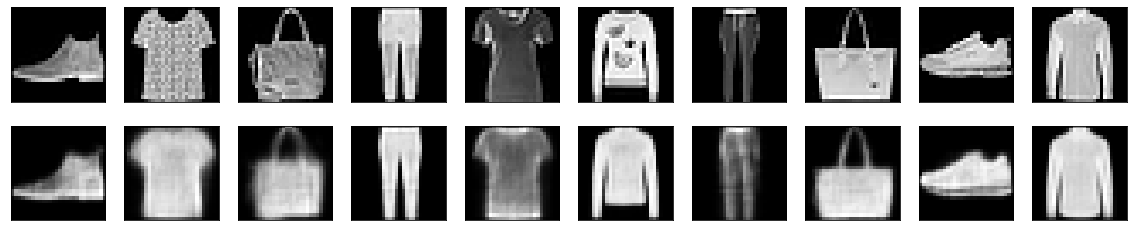

In [40]:
n = 10 
plt.figure(figsize=(20, 4))

for i in range(n):
    #  = pit.subplot(행의 갯수, 열의갯수, index )
    ax = plt.subplot(2, 10, i + 1)
    
    image = test_img[i*1000].reshape(28,28)
    plt.imshow(image.cpu(), cmap='gray')
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, 10, i+1+n)
    
    recon_image = test_recon_x.data[i*1000].cpu().reshape(28,28)
    plt.imshow(recon_image, cmap='gray')

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)